In [28]:
%load_ext autoreload
%autoreload 2

# Get parent root directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from src.rocket import Rocket
from src.pos_rocket_vis import *
from nmpc_land import NmpcCtrl
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir,"rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 0.2

In [30]:
sim_time = 10  # simulation length in seconds
x0 = np.array([0, 0, 0, 0, 0, np.deg2rad(30), 0, 0, 0, 3, 2, 10])  # w, phi, v, p
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Reference: hover at position [1, 0, 3]
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

H = 3  # horizon time in seconds
nmpc = NmpcCtrl(rocket, H, xs, us)

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


In [31]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(nmpc, sim_time, H, x0)

Simulating time 0.00
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00


Settling time: 3.20 seconds
Final position error: 0.0000 m
Final velocity magnitude: 0.0000 m/s
Final attitude magnitude: 0.0018 rad (0.10 deg)


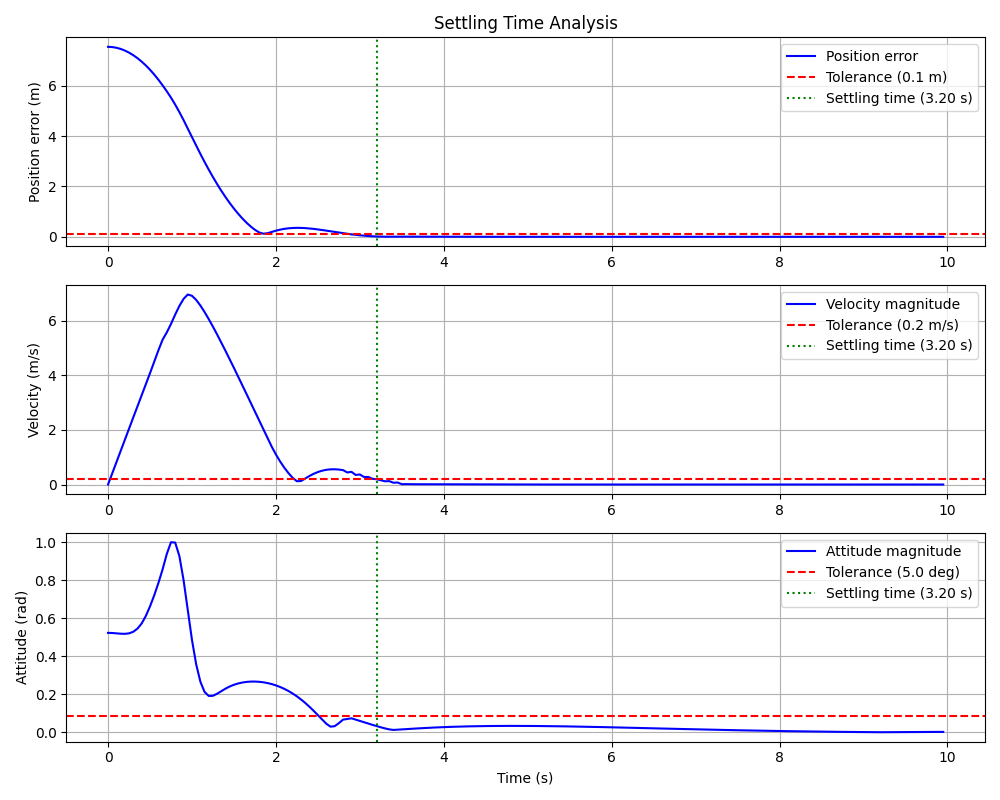

In [32]:
# Calculate settling time
# Settling time: time when system reaches and stays within tolerance of target

# Define tolerances
pos_tolerance = 0.1  # meters - position error tolerance
vel_tolerance = 0.2  # m/s - velocity magnitude tolerance
att_tolerance = np.deg2rad(5)  # radians - attitude angle tolerance (5 degrees)

# Calculate errors at each time step
N = len(t_cl) - 1
settled = np.zeros(N, dtype=bool)

for i in range(N):
    # Position error (x, y, z indices: 9, 10, 11)
    pos_error = np.linalg.norm(x_cl[9:12, i] - xs[9:12])
    
    # Velocity magnitude (vx, vy, vz indices: 6, 7, 8)
    vel_mag = np.linalg.norm(x_cl[6:9, i])
    
    # Attitude angle magnitude (alpha, beta, gamma indices: 3, 4, 5)
    att_mag = np.linalg.norm(x_cl[3:6, i])
    
    # Check if within tolerance
    if pos_error <= pos_tolerance and vel_mag <= vel_tolerance and att_mag <= att_tolerance:
        settled[i] = True

# Find settling time: first time that stays settled for the rest
settling_time = None
for i in range(N):
    # Check if settled from this point forward
    if np.all(settled[i:]):
        settling_time = t_cl[i]
        break

if settling_time is not None:
    print(f"Settling time: {settling_time:.2f} seconds")
    print(f"Final position error: {np.linalg.norm(x_cl[9:12, -1] - xs[9:12]):.4f} m")
    print(f"Final velocity magnitude: {np.linalg.norm(x_cl[6:9, -1]):.4f} m/s")
    print(f"Final attitude magnitude: {np.linalg.norm(x_cl[3:6, -1]):.4f} rad ({np.rad2deg(np.linalg.norm(x_cl[3:6, -1])):.2f} deg)")
else:
    print("System did not settle within tolerance during simulation")
    print(f"Final position error: {np.linalg.norm(x_cl[9:12, -1] - xs[9:12]):.4f} m")
    print(f"Final velocity magnitude: {np.linalg.norm(x_cl[6:9, -1]):.4f} m/s")
    print(f"Final attitude magnitude: {np.linalg.norm(x_cl[3:6, -1]):.4f} rad ({np.rad2deg(np.linalg.norm(x_cl[3:6, -1])):.2f} deg)")

# Plot settling indicators
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Position error - x_cl shape is (12, N+1)
pos_errors = [np.linalg.norm(x_cl[9:12, i] - xs[9:12]) for i in range(N)]
axes[0].plot(t_cl[:-1], pos_errors, 'b-', label='Position error')
axes[0].axhline(y=pos_tolerance, color='r', linestyle='--', label=f'Tolerance ({pos_tolerance} m)')
if settling_time is not None:
    axes[0].axvline(x=settling_time, color='g', linestyle=':', label=f'Settling time ({settling_time:.2f} s)')
axes[0].set_ylabel('Position error (m)')
axes[0].set_title('Settling Time Analysis')
axes[0].legend()
axes[0].grid(True)

# Velocity magnitude
vel_mags = [np.linalg.norm(x_cl[6:9, i]) for i in range(N)]
axes[1].plot(t_cl[:-1], vel_mags, 'b-', label='Velocity magnitude')
axes[1].axhline(y=vel_tolerance, color='r', linestyle='--', label=f'Tolerance ({vel_tolerance} m/s)')
if settling_time is not None:
    axes[1].axvline(x=settling_time, color='g', linestyle=':', label=f'Settling time ({settling_time:.2f} s)')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].legend()
axes[1].grid(True)

# Attitude magnitude
att_mags = [np.linalg.norm(x_cl[3:6, i]) for i in range(N)]
axes[2].plot(t_cl[:-1], att_mags, 'b-', label='Attitude magnitude')
axes[2].axhline(y=att_tolerance, color='r', linestyle='--', label=f'Tolerance ({np.rad2deg(att_tolerance):.1f} deg)')
if settling_time is not None:
    axes[2].axvline(x=settling_time, color='g', linestyle=':', label=f'Settling time ({settling_time:.2f} s)')
axes[2].set_ylabel('Attitude (rad)')
axes[2].set_xlabel('Time (s)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', interval=250, max=199), IntSlider(v…

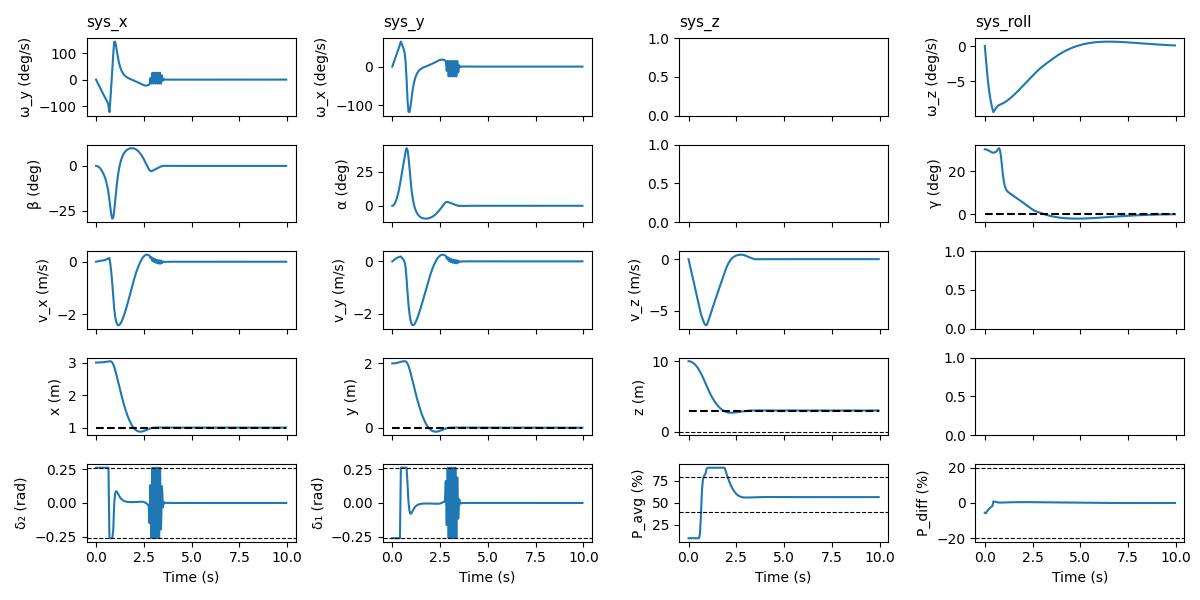

In [33]:
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)